In [ ]:
COLAB = 'google.colab' in str(get_ipython())
if COLAB:
    from google.colab import drive
    drive.mount('/content/drive/')
    %cd /content/drive/MyDrive/Thesis/

In [1]:
import real_stuff.evaluating as evaluating
import real_stuff.simulating as simulating
import real_stuff.training as training
from real_stuff.basic_imports import *

import importlib  # doesn't work too well in Colab

Sit 5: sampling 30000 X_i ~ 1D uniform. f1(X) = X ** 5. K = 2. Alpha = 1 / m.
X:
 [0.375 0.951 0.732 ... 0.019 0.401 0.257]
Normalized funcs(X) = Y probabilities:
[[0.007 0.993]
 [0.777 0.223]
 [0.21  0.79 ]
 ...
 [0.    1.   ]
 [0.01  0.99 ]
 [0.001 0.999]]
Unnormalized funcs(X):
[[0.007 0.993]
 [0.777 0.223]
 [0.21  0.79 ]
 ...
 [0.    1.   ]
 [0.01  0.99 ]
 [0.001 0.999]]
Euclidean distance between those: 0.0


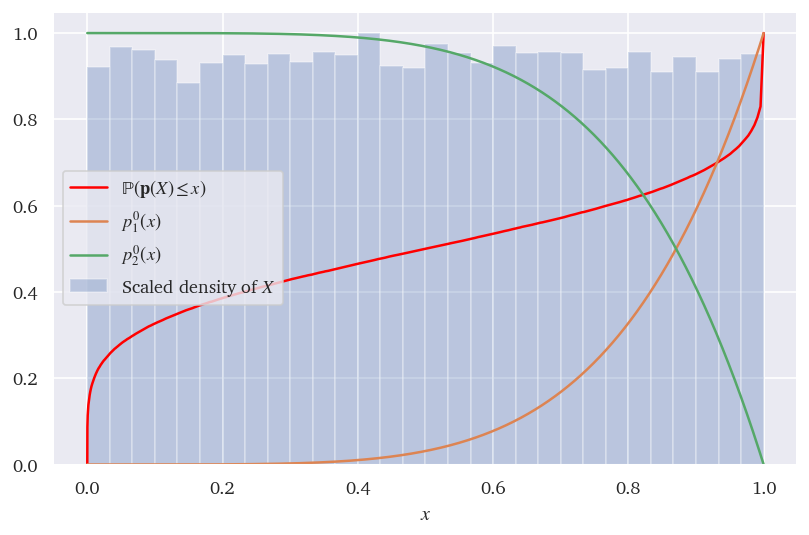

In [21]:
importlib.reload(simulating)
situation = 5

X, funcs, Y_prob = simulating.create_dataset(str(situation), n=30000, viz=True)

Max 0/1-accuracy during training: 0.5834
Epoch 1/420
1600/1600 [==============================] - 3s 2ms/step - loss: 0.7297 - accuracy: 0.5458 - val_loss: 0.6953 - val_accuracy: 0.5831
Epoch 2/420
1600/1600 [==============================] - 3s 2ms/step - loss: 0.6986 - accuracy: 0.5471 - val_loss: 0.6953 - val_accuracy: 0.5675
Epoch 3/420
1600/1600 [==============================] - 2s 2ms/step - loss: 0.6963 - accuracy: 0.5564 - val_loss: 0.6925 - val_accuracy: 0.5804
Epoch 4/420
1600/1600 [==============================] - 3s 2ms/step - loss: 0.6962 - accuracy: 0.5556 - val_loss: 0.6925 - val_accuracy: 0.5823
Epoch 5/420
1600/1600 [==============================] - 2s 2ms/step - loss: 0.6975 - accuracy: 0.5484 - val_loss: 0.6934 - val_accuracy: 0.5817
Epoch 6/420
1600/1600 [==============================] - 3s 2ms/step - loss: 0.6951 - accuracy: 0.5547 - val_loss: 0.6914 - val_accuracy: 0.5819
Epoch 7/420
1600/1600 [==============================] - 3s 2ms/step - loss: 0.6949 - acc

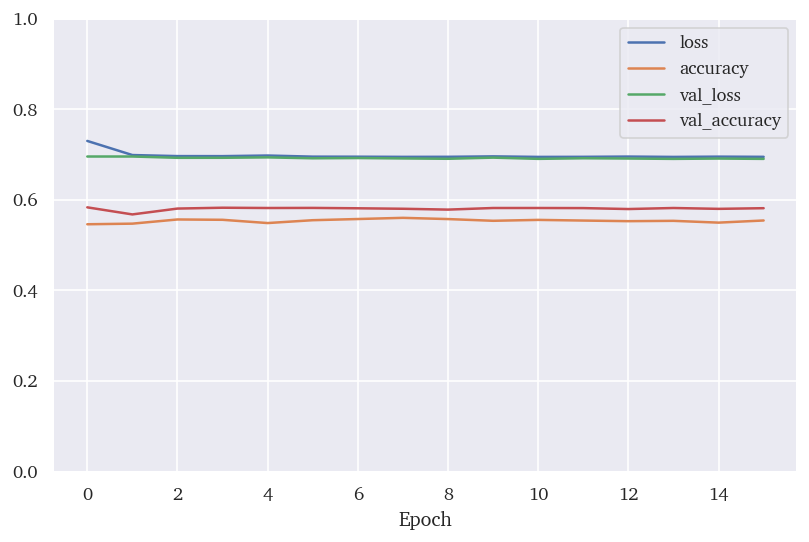

In [17]:
importlib.reload(training)
model, X_test, Y_test, Y_prob_test = training.train_network(X, Y_prob, viz=1)

In [18]:
importlib.reload(evaluating)
evaluating.get_all_quantities_of_interest(model, X_test, Y_test, Y_prob_test)

{'One-hot log-likelihood': 0.68250686,
 'One-hot KL divergence': 0.68250585,
 'Probability vec log-likelihood': 0.68166447,
 'Probability vec KL divergence': 0.006792812,
 'Pr vec KL div truncated (at 0.5)': 0.5,
 '~ inf norm diff': 0.125107658252135,
 'Biases > epsilon': 18,
 'Total biases': 66,
 'Weights > epsilon': 31,
 'Total weights': 816,
 'Epsilon': 0.001,
 's': 49}

Some examples from test set:
X:
[[0.686]
 [0.468]
 [0.056]
 ...
 [0.019]
 [0.401]
 [0.257]]
True:
[[0.562 0.438]
 [0.489 0.511]
 [0.352 0.648]
 ...
 [0.34  0.66 ]
 [0.467 0.533]
 [0.419 0.581]]
Predict:
[[0.527 0.473]
 [0.491 0.509]
 [0.458 0.542]
 ...
 [0.458 0.542]
 [0.481 0.519]
 [0.459 0.541]]


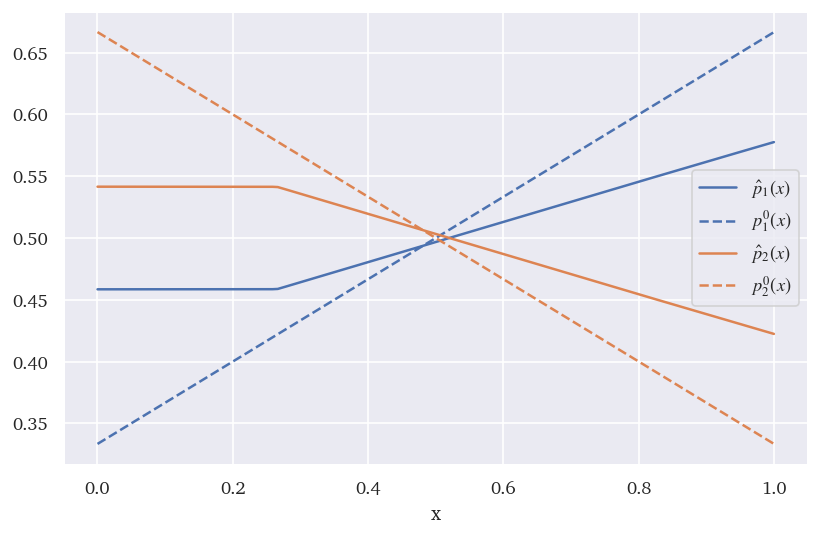

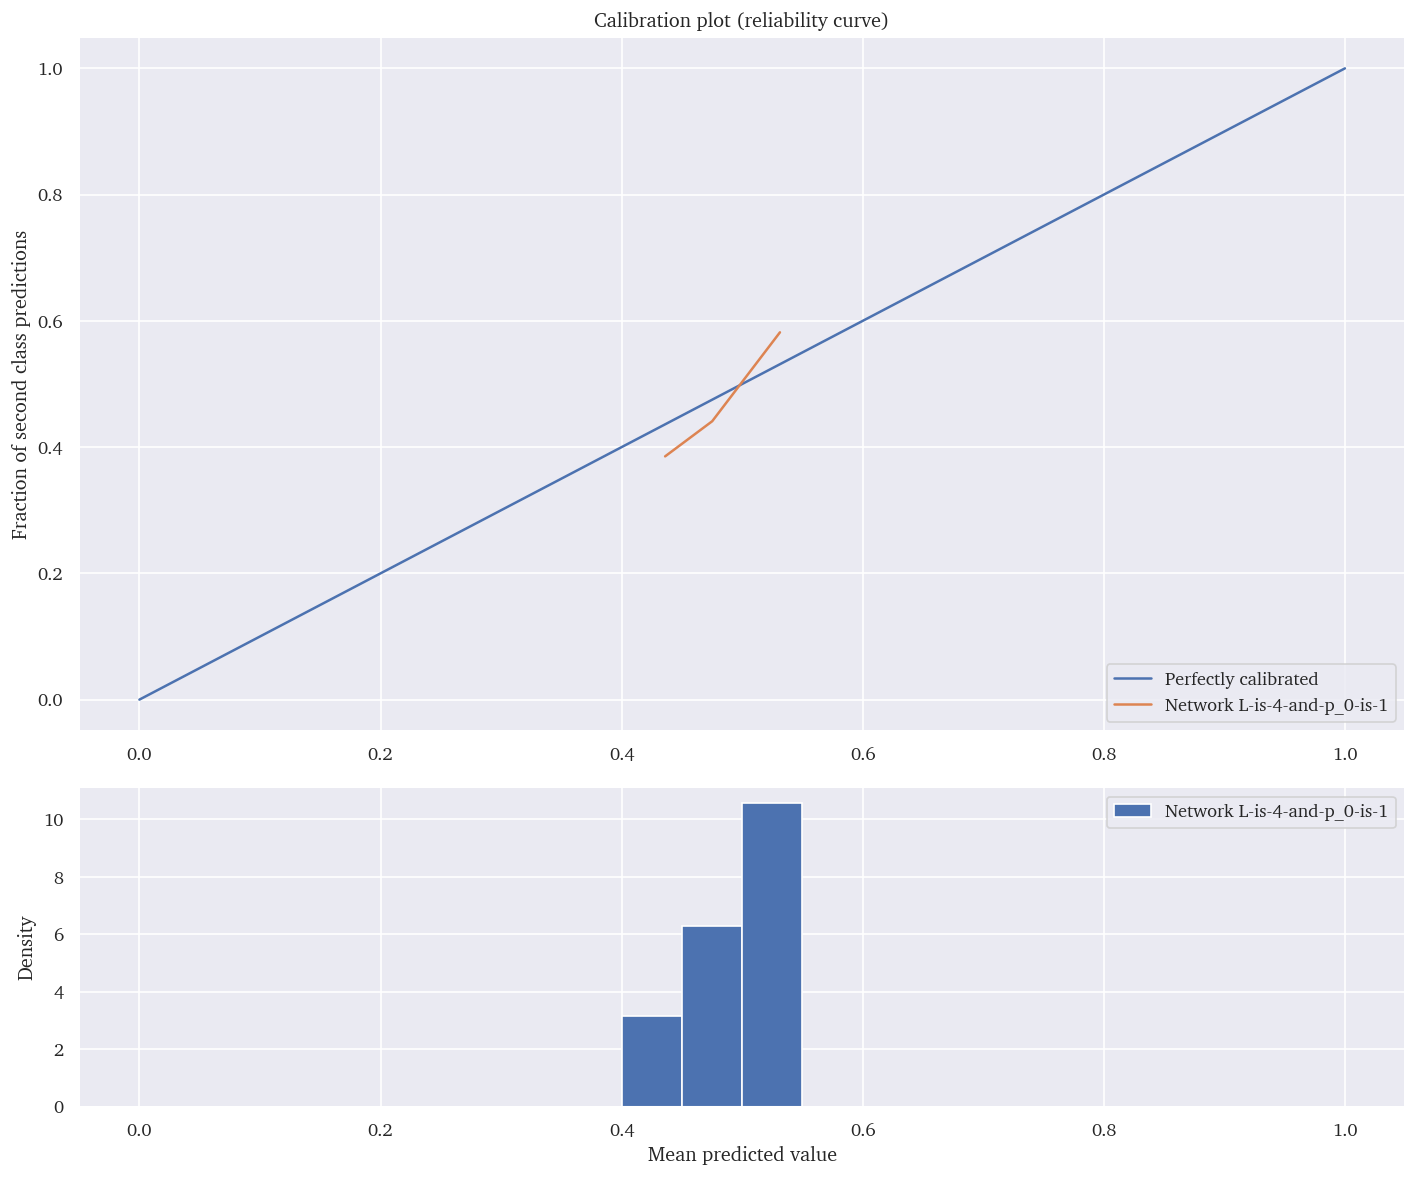

In [19]:
importlib.reload(evaluating)
evaluating.visualize(model, X_test, Y_test, Y_prob_test)

## Temp

In [ ]:
!python test.py 6.2

2.0
{'t^0.2': array([0.1       , 0.10001924, 0.10003847, ..., 0.68399227, 0.68412384,
       0.68425543])}


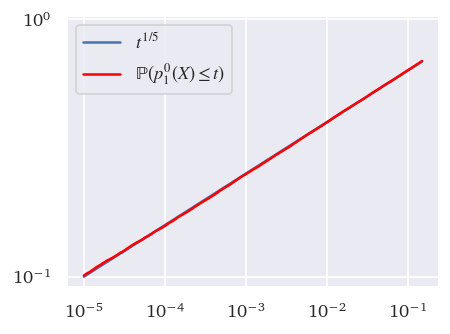

In [40]:
# NOTE: I've destroyed this thing but it's useless anyway

def alpha_C_finder(t_space, p_X_small, alphas):
    # TODO!!
    result = {}
    for alpha in alphas:
        t_alpha = np.power(t_space, alpha)
        C = np.ceil(np.max(p_X_small / t_alpha))
        print(C)
        result[f't^{alpha}'] = t_alpha
    return result


t_space = np.geomspace(1e-5, 0.15, 10_000)
p_X_small = np.array([np.mean(Y_prob[:, 0] <= t) for t in t_space])
alphas = [1 / 5]
results = alpha_C_finder(t_space, p_X_small, alphas)
print(results)

rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix",
      "figure.dpi": 120,
      "figure.figsize": [4, 3]
     }
plt.rcParams.update(rc)

for alpha in alphas:
    C_t_alpha = results[f't^{alpha}']

    plt.plot(t_space, C_t_alpha, label="$t^{1/5}$")
    plt.plot(t_space, p_X_small, label="$\mathrm{\mathbb{P}}(p^0_1(X) \leq t)$",
             color="red")
    plt.legend()
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim(top=max(p_X_small) * 1.5)
    plt.savefig("empi.pdf")
    plt.show()

In [ ]:
!python test.py 6.8

In [ ]:
def f1(X, m=30):
#     y = 0
#     for k in range(0, m, 1):
#         y += ((-1)**k)*(X**(1+2*k))/np.math.factorial(1+2*k)
#     return y
    return sum(
        [(-1) ** (i+1) * X ** (2*i-1) / np.math.factorial(2*i-1) for i in range(1, m, 1)]) + .00001


X = np.random.uniform(size=1000)
order = np.argsort(X)
plt.plot(X[order], f1(X[order], 50), color='red')
plt.plot(X[order], np.sin(X[order]), color='blue')
f1(1), np.sin(1)